# Temperature Variations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
# sns.set_theme('whitegrid')

import matplotlib as mpl
mpl.rcParams['axes.labelsize']  = 18
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize']  = 18


In [2]:
from astropy.io.fits import getheader, getdata
from astropy.table import Table
import sep

In [3]:
def convert_to_dict(obj):
    out = dict()
    keynames = objects.dtype.names
    for col in keynames:
        out[col] = obj[col]
    return out

def plot_gradient(coord,y,axs=None,label=''):
    if axs is None: axs = plt.gca()
    coefs = np.polyfit(coord/8000,y,1)
    x = np.linspace(coord.min(),coord.max(),100)
    yn = np.poly1d(coefs)(x/8000)
    rms = np.std(np.poly1d(coefs)(coord/8000)-y)
    
    axs.plot(x,yn,'k')
    axs.scatter(coord,y,label=label+'\n'+r'$ m, b = %.3f, %.3f $'%(coefs[0],coefs[1]))
    
def plot_hist(x,nbins=15,label=''):
    std = np.nanstd(x)
    xm = np.nanmean(x)
    xbins = np.linspace(xm-3.*std,xm+3.*std,nbins)
    plt.hist(x,bins=xbins,label=label+'  '+'mean, std: %.2f, %.2f'%(xm,std))
    #plt.axvline(xm,color='gray')
    #plt.axvline(xm-std,ls='--',color='gray')
    #plt.axvline(xm+std,ls='--',color='gray')

## Load Files

In [4]:
# arasmus_nm1020_even_rb8.fit arasmus_nm1050_odd_rb8.fit
file_red = '../data/arasmus_nm1020_even_rb8.fit'
file_y = '../data/arasmus_nm1050_odd_rb8.fit'

img1 = getdata(file_red)
img2 = getdata(file_y)

## Slice

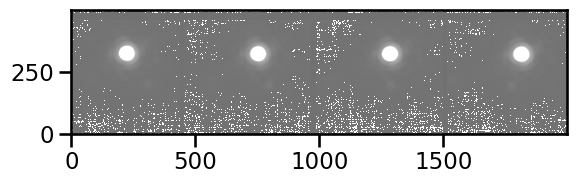

In [5]:
ix = 200
slice1 = img1[5350:5350+500, 2000+ix:4000+ix].copy()
slice1 = np.where(slice1<0.,np.nan, slice1)
m, s = np.nanmean(slice1.flatten()), np.nanstd(slice1.flatten())
plt.imshow(slice1, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')


In [6]:
objects = sep.extract(slice1, 100.)
len(objects)

4

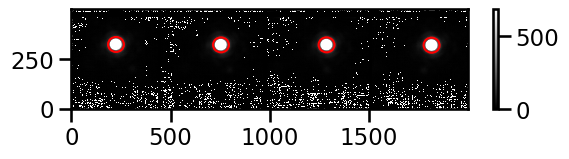

In [7]:
from matplotlib.patches import Ellipse

p5,p95 = np.nanpercentile(slice1.flatten(),[1.0,99.0])
# plot background-subtracted image
fig, ax = plt.subplots()
plt.imshow(slice1, interpolation='nearest', cmap='gray', vmin=p5, vmax=p95, origin='lower')
# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.colorbar(shrink=0.27);
# plt.tight_layout()

In [8]:
Table(convert_to_dict(objects))

thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
100.0,6739,6707,707,803,275,365,754.2366028033962,320.946841274906,177.3500882015437,156.86854659467735,-0.5674714116075847,0.0,0.0,0.0,13.317874908447266,12.524089813232422,-0.027678173035383224,0.0056386301293969154,0.006374837830662727,4.0795450331643224e-05,8977435.0,8977936.0,9128.21484375,9195.2197265625,755,321,755,321,0
100.0,6978,6949,1768,1865,272,365,1815.7699788436216,319.3058740434592,180.13970102588792,159.9667118309576,-1.9374972239329509,0.0,0.0,0.0,13.428481101989746,12.6405029296875,-0.09488833695650101,0.005551970563828945,0.006252115126699209,0.00013448957179207355,9410330.0,9410882.0,9613.044921875,9690.9580078125,1817,318,1815,318,0
100.0,6769,6728,1239,1335,275,366,1286.3062934042644,321.091499550787,177.97649507595634,157.41413288499098,-1.0645983705330764,0.0,0.0,0.0,13.342843055725098,12.54428768157959,-0.05159026384353638,0.005618946626782417,0.006352926604449749,7.600234675919637e-05,9019650.0,9020169.0,9256.748046875,9354.2900390625,1285,321,1285,321,0
100.0,6798,6762,179,274,276,368,225.0809122208728,323.0251667237967,177.3547128767832,158.319685499343,-0.7010165736546696,0.0,0.0,0.0,13.318427085876465,12.581490516662598,-0.0367613323032856,0.005638516508042812,0.006316444370895624,4.9933067202800885e-05,9118090.0,9118619.0,9502.8984375,9550.9208984375,226,324,226,324,0


## Photometry

### MAG_AUTO

In [9]:
# FWHM
fwhm = 2*np.sqrt(objects['x2']+objects['y2']/2.)

# 90% Flux
flux90, _fluxerr, _flag = sep.sum_circle(slice1, objects['x'], objects['y'], 2*fwhm)
np.log10(flux90/flux90.mean())

array([-0.00719053,  0.01260518, -0.00511402, -0.00057492])

In [10]:
half_light_radii, flag = sep.flux_radius(slice1, objects['x'], objects['y'], 6.*fwhm, 0.5,
                          normflux=objects['flux'], subpix=5)
half_light_radii

array([14.53765506, 14.59029503, 14.56811582, 14.55493873])

In [11]:
flux, _fluxerr, _flag = sep.sum_circle(slice1, objects['x'], objects['y'], half_light_radii)
np.log10(flux/flux.mean())

array([-0.00749472,  0.01310823, -0.00533855, -0.00057215])

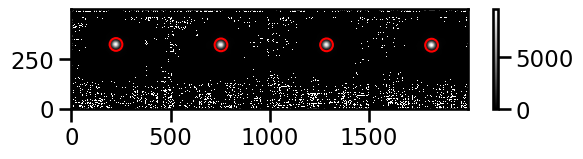

In [12]:
from matplotlib.patches import Ellipse

p5,p95 = np.nanpercentile(slice1.flatten(),[0.001,99.999])
# plot background-subtracted image
fig, ax = plt.subplots()
plt.imshow(slice1, interpolation='nearest', cmap='gray', vmin=p5, vmax=p95, origin='lower')
# plot an ellipse for each objecta
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=2*fwhm[i],
                height=2*fwhm[i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.colorbar(shrink=0.27);
# plt.tight_layout()

# Full Focal Plane

In [13]:
# objects[]

In [14]:
from astropy.table import Table
def run_sextractor(img, th=80):
    img = np.where(img<0.,np.nan,img)
    bkg = sep.Background(img)
    img_sub = img-bkg
    objects = sep.extract(img_sub, th, err=bkg.globalrms)
    print(f'Number of Objects Detected {len(objects)}')
    
    # FWHM
    fwhm = 2*np.sqrt((objects['x2']+objects['y2'])/2.)

    # 90% Flux
    flux90, fluxerr90, _flag = sep.sum_circle(img, objects['x'], objects['y'], 2*fwhm)
    
    # half-light-radius
    half_light_radii, flag = sep.flux_radius(img, objects['x'], objects['y'], 6.*fwhm, 0.5,
                          normflux=flux90, subpix=5)
    
    flux50, fluxerr50, _flag = sep.sum_circle(img, objects['x'], objects['y'], half_light_radii)
    
    out = convert_to_dict(objects)
    out['T'] = np.sqrt(out['x2']+out['y2'])
    out['fwhm'] = fwhm
    out['r50'] = half_light_radii
    out['flux90'] = flux90
    out['flux90_err'] = fluxerr90
    out['flux50'] = flux50
    out['flux50_err'] = fluxerr50
    return Table(out)

In [15]:
s1 = run_sextractor(img1)
s1

Number of Objects Detected 249


thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,T,fwhm,r50,flux90,flux90_err,flux50,flux50_err
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64
110.09062957763672,549,410,1852,1916,15,77,1902.2334906475571,38.47781542483075,16.566187344338232,266.85299838268793,13.53191479344082,4.214310193461663e-11,1.7528915566263167e-10,2.7198294719534663e-11,16.357948303222656,3.9795353412628174,1.5169399976730347,0.06297231465578079,0.0039093103259801865,-0.0063865575939416885,46597568.0,46643864.0,200344.34375,303366.03125,1903,42,1903,16,0,16.835058233550193,23.808367677227523,nan,nan,0.0,0.0,0.0
110.09062957763672,504,498,1893,1905,290,411,1902.0844399885161,364.244818421073,4.628357949346267,318.4794121508885,-6.718204938600252,2.2669962321580363e-12,3.6599005227595753e-10,-8.48304207208365e-12,17.850017547607422,2.1176910400390625,-1.5494036674499512,0.222883939743042,0.0032391001004725695,0.009403307922184467,46593048.0,47560256.0,283244.5625,347940.8125,1899,372,1898,371,0,17.975198749950852,25.420769858532402,nan,nan,0.0,0.0,0.0
110.09062957763672,7380,7348,4982,5086,327,419,5034.329425041228,374.18587545999435,198.72348423394806,158.80512816296823,-0.6928522012335634,6.091111027385978e-08,4.831777167339132e-08,-2.835367060115236e-10,14.097357749938965,12.601313591003418,-0.017349764704704285,0.005032194312661886,0.0062971217557787895,4.3910004023928195e-05,12325387.0,12326135.0,12352.921875,12458.0869140625,5035,375,5035,374,0,18.90842702069414,26.740553935807547,15.123198376761858,12653447.123160709,0.0,6330819.857109372,0.0
110.09062957763672,7310,7278,5511,5614,326,419,5562.751349829544,373.3282282098809,197.46222863560797,159.3633070603655,-0.8813605325999561,6.559930951329958e-08,5.284731457751539e-08,-5.411297218456285e-10,14.052850723266602,12.6231107711792,-0.02311699092388153,0.005064384546130896,0.006275125313550234,5.601727025350556e-05,11712787.0,11713556.0,11780.3271484375,11858.4150390625,5562,374,5562,374,0,18.889826248432605,26.714248471404673,15.089940579710166,11989456.459383838,0.0,5997456.40607422,0.0
110.09062957763672,7287,7262,4450,4553,328,420,4501.8190654970995,374.9629746648809,198.67129159808883,157.82470265564007,-0.9209153762431015,6.511953518581204e-08,5.192090636072159e-08,-5.222267956306112e-10,14.095816612243652,12.562004089355469,-0.02253044955432415,0.005033575929701328,0.00633631506934762,5.874235648661852e-05,11751741.0,11752483.0,11832.560546875,11891.22265625,4502,375,4502,375,0,18.8811015106039,26.701909828839167,15.107607133016822,12048027.661271198,0.0,6027026.452832031,0.0
110.09062957763672,7393,7356,3919,4023,330,422,3971.791514174177,377.0345618464012,200.6081032929087,159.44253181180557,-1.0193040602707697,6.552656764660745e-08,5.2033707315348325e-08,-6.989666020294249e-10,14.164509773254395,12.626056671142578,-0.02474086917936802,0.004985005594789982,0.0062720561400055885,6.373752694344148e-05,11893725.0,11894476.0,11875.5380859375,11924.875,3972,377,3972,377,0,18.97500026626388,26.83470272258347,15.138268013661632,12180692.372010812,0.0,6090228.606132813,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110.09062957763672,7312,7294,1853,1957,7211,7303,1905.492692149839,7258.092658378642,199.92619438069596,159.7350520499267,-0.7707559114592186,6.577920678499624e-08,5.2531771021078785e-08,-5.937697174991775e-10,14.140048027038574,12.638049125671387,-0.019167862832546234,0.0050019389018416405,0.006260483060032129,4.8270856495946646e-05,11730728.0,11731447.0,11642.1455078125,11689.9296875,1906,7258,1906,7258,0,18.964736919625928,26.820188158572737,15.190696924952961,1203

Number of selected sources: 179


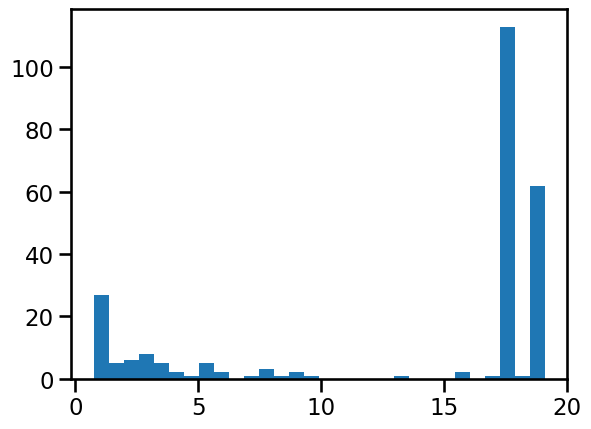

In [16]:
nsources = np.count_nonzero(np.array(s1['T'])>15.)
print(f'Number of selected sources: {nsources}')
_  = plt.hist(s1['T'],bins=30)

174


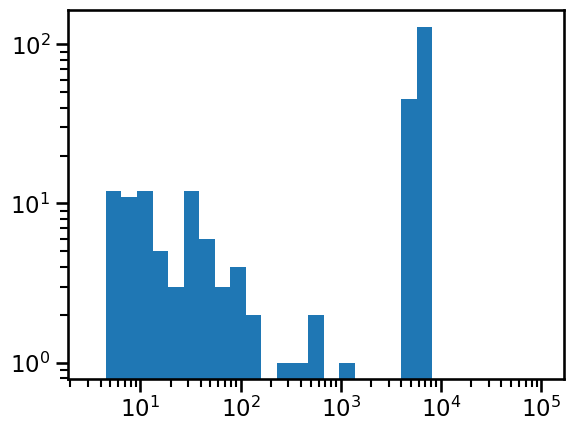

In [17]:
mask = s1['npix']>4e3
print(np.count_nonzero(mask))
plt.loglog()
_ = plt.hist(s1['npix'],bins=np.logspace(0.5,5.,30))


In [18]:
data = s1[mask]
data

thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,T,fwhm,r50,flux90,flux90_err,flux50,flux50_err
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64
110.09062957763672,7380,7348,4982,5086,327,419,5034.329425041228,374.18587545999435,198.72348423394806,158.80512816296823,-0.6928522012335634,6.091111027385978e-08,4.831777167339132e-08,-2.835367060115236e-10,14.097357749938965,12.601313591003418,-0.017349764704704285,0.005032194312661886,0.0062971217557787895,4.3910004023928195e-05,12325387.0,12326135.0,12352.921875,12458.0869140625,5035,375,5035,374,0,18.90842702069414,26.740553935807547,15.123198376761858,12653447.123160709,0.0,6330819.857109372,0.0
110.09062957763672,7310,7278,5511,5614,326,419,5562.751349829544,373.3282282098809,197.46222863560797,159.3633070603655,-0.8813605325999561,6.559930951329958e-08,5.284731457751539e-08,-5.411297218456285e-10,14.052850723266602,12.6231107711792,-0.02311699092388153,0.005064384546130896,0.006275125313550234,5.601727025350556e-05,11712787.0,11713556.0,11780.3271484375,11858.4150390625,5562,374,5562,374,0,18.889826248432605,26.714248471404673,15.089940579710166,11989456.459383838,0.0,5997456.40607422,0.0
110.09062957763672,7287,7262,4450,4553,328,420,4501.8190654970995,374.9629746648809,198.67129159808883,157.82470265564007,-0.9209153762431015,6.511953518581204e-08,5.192090636072159e-08,-5.222267956306112e-10,14.095816612243652,12.562004089355469,-0.02253044955432415,0.005033575929701328,0.00633631506934762,5.874235648661852e-05,11751741.0,11752483.0,11832.560546875,11891.22265625,4502,375,4502,375,0,18.8811015106039,26.701909828839167,15.107607133016822,12048027.661271198,0.0,6027026.452832031,0.0
110.09062957763672,7393,7356,3919,4023,330,422,3971.791514174177,377.0345618464012,200.6081032929087,159.44253181180557,-1.0193040602707697,6.552656764660745e-08,5.2033707315348325e-08,-6.989666020294249e-10,14.164509773254395,12.626056671142578,-0.02474086917936802,0.004985005594789982,0.0062720561400055885,6.373752694344148e-05,11893725.0,11894476.0,11875.5380859375,11924.875,3972,377,3972,377,0,18.97500026626388,26.83470272258347,15.138268013661632,12180692.372010812,0.0,6090228.606132813,0.0
110.09062957763672,7201,7178,2857,2961,335,425,2909.3046474021676,380.87572720005494,200.68149992826238,156.98346765838414,-1.0224544012730803,6.771085979461227e-08,5.2449232410106106e-08,-6.74361113166805e-10,14.16705322265625,12.528349876403809,-0.023381121456623077,0.004983185790479183,0.006370308808982372,6.491231761174276e-05,11471507.0,11472286.0,11418.5908203125,11511.77734375,2909,381,2908,380,0,18.912032349450087,26.745652640631018,15.187385398371399,11790417.86861253,0.0,5902007.786249997,0.0
110.09062957763672,7420,7390,2326,2432,334,427,2379.929991629878,381.5591688859333,201.56688383135725,159.36047936800833,-1.2295568458744128,6.514330562500192e-08,5.125389893365075e-08,-7.151413360715126e-10,14.198685646057129,12.62238883972168,-0.029099099338054657,0.004961365833878517,0.00627537677064538,7.655952504137531e-05,11999288.0,12000021.0,11832.240234375,11920.0166015625,2379,382,2380,382,0,18.998088409083834,26.867354287289455,15.148734378792737,12294814.038818516,0.0,6149675.939257814,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110.09062957763672,7312,7294,1853,1957,7211,7303,1905.492692149839,7258.092658378642,199.92619438069596,159.7350520499267,-0.7707559114592186,6.577920678499624e-08,5.2531771021078785e-08,-5.937697174991775e-10,14.140048027038574,12.638049125671387,-0.019167862832546234,0.0050019389018416405,0.006260483060032129,4.8270856495946646e-05,11730728.0,1173144

In [19]:
s2 = run_sextractor(img2)


Number of Objects Detected 235


174


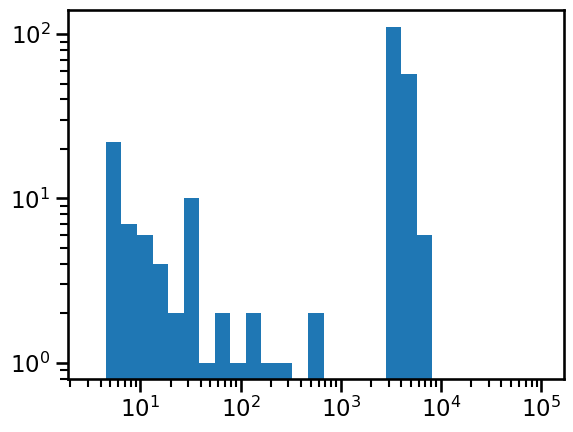

In [20]:
mask = s2['npix']>1e3
print(np.count_nonzero(mask))
plt.loglog()
_ = plt.hist(s2['npix'],bins=np.logspace(0.5,5.,30))


In [21]:
mask = s2['npix']>1e3
print(np.count_nonzero(mask))
data2 = s2[mask]

174


Now let's compute temperature diffirences

## Check Detections

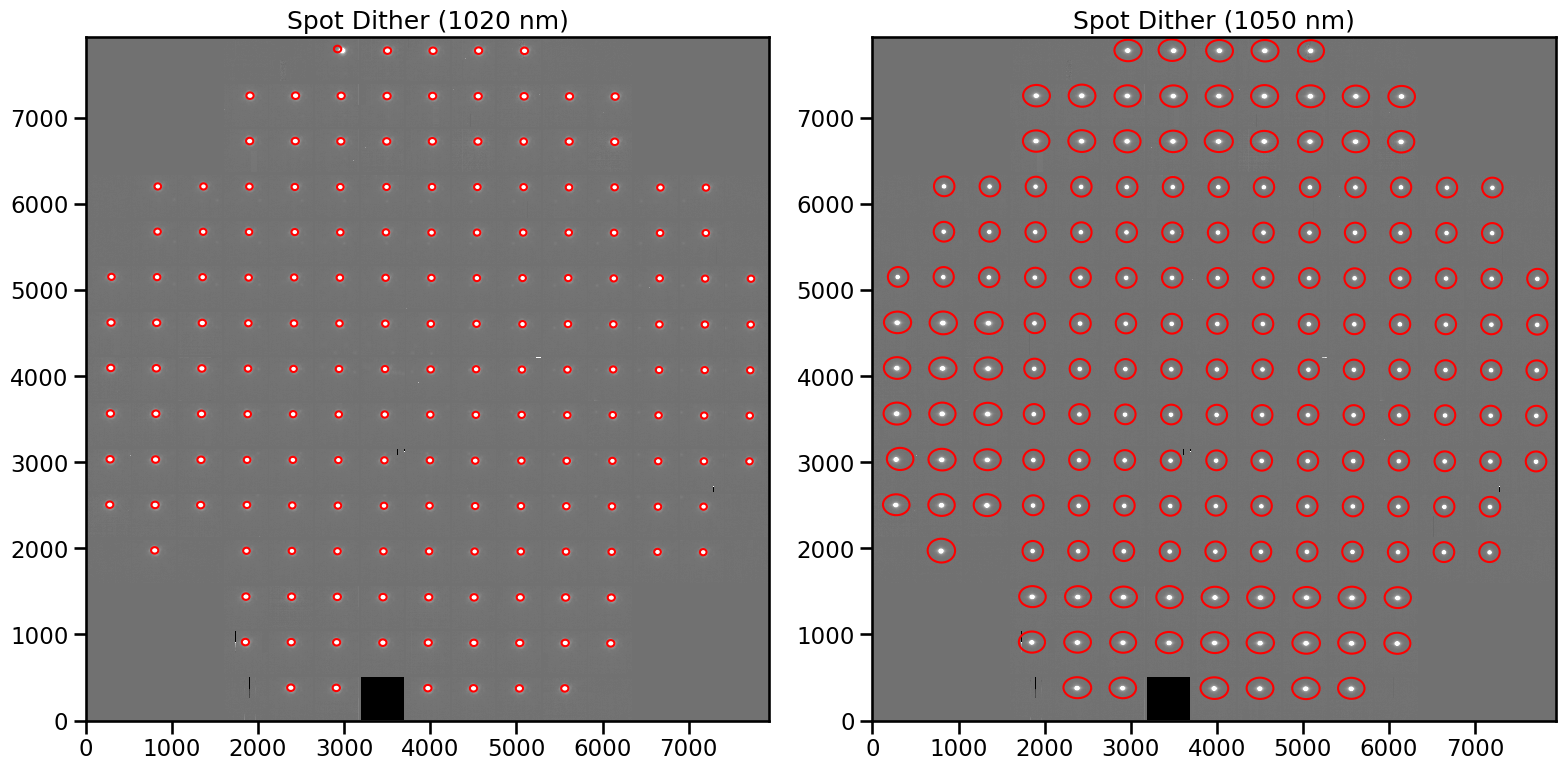

In [23]:
fig, axs = plt.subplots(1,2, figsize=(16,8))
mask = np.abs(img1)<100.
ax = axs[0]
p1,p99 = np.nanpercentile(img1[mask].flatten(),[0.005,99.995])
ax.imshow(img1, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
for i in range(len(data)):
    e = Ellipse(xy=(data['xpeak'][i], data['ypeak'][i]),
                width=6*data['a'][i],
                height=6*data['b'][i],
                angle=data['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

# plt.colorbar(shrink=0.7);
ax.set_title(r'Spot Dither (1020 nm)')

ax = axs[1]
p1,p99 = np.nanpercentile(img2[mask].flatten(),[0.005,99.995])
ax.imshow(img2, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
for i in range(len(data2)):
    e = Ellipse(xy=(data2['xpeak'][i], data2['ypeak'][i]),
                width=20*data2['a'][i],
                height=20*data2['b'][i],
                angle=data['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

# plt.colorbar(shrink=0.7);
ax.set_title(r'Spot Dither (1050 nm)')
plt.tight_layout()
plt.savefig(r'full_focal_plane_spot_temp_variation_source_detection.png',dpi=150)

## Gain Variations Due To Temperature Offsets

In [24]:
def plot_hist(x,nbins=15,label=''):
    std = np.nanstd(x)
    xm = np.nanmean(x)
    xbins = np.linspace(xm-3.*std,xm+3.*std,nbins)
    plt.hist(x,bins=xbins,label=label+'  '+'mean, std: %.2f, %.2f'%(xm,std))
    #plt.axvline(xm,color='gray')
    #plt.axvline(xm-std,ls='--',color='gray')
    #plt.axvline(xm+std,ls='--',color='gray')

## At 1020nm

In [25]:
flux = data['flux']
print('Flux mean, std: %.2e, %.2e'%(flux.mean(),flux.std()))

Flux mean, std: 1.01e+07, 1.41e+06


In [26]:
dflux = flux/np.nanmean(flux)
data['df'] = dflux

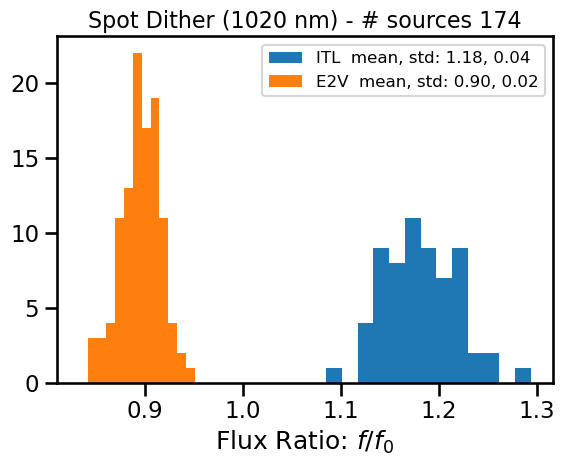

In [27]:
plt.figure(figsize=(6,5))
itl = dflux>1.
plot_hist(dflux[itl],label='ITL')
plot_hist(dflux[~itl],label='E2V')
plt.legend(fontsize=12,loc=1)
plt.xlabel(r'Flux Ratio: $ f/f_0$')
plt.title(f'Spot Dither (1020 nm) - # sources {len(data)}',fontsize=16)
plt.tight_layout()
plt.savefig(r'flux_dist_spot_temp_variation_1020nm.png',dpi=150)

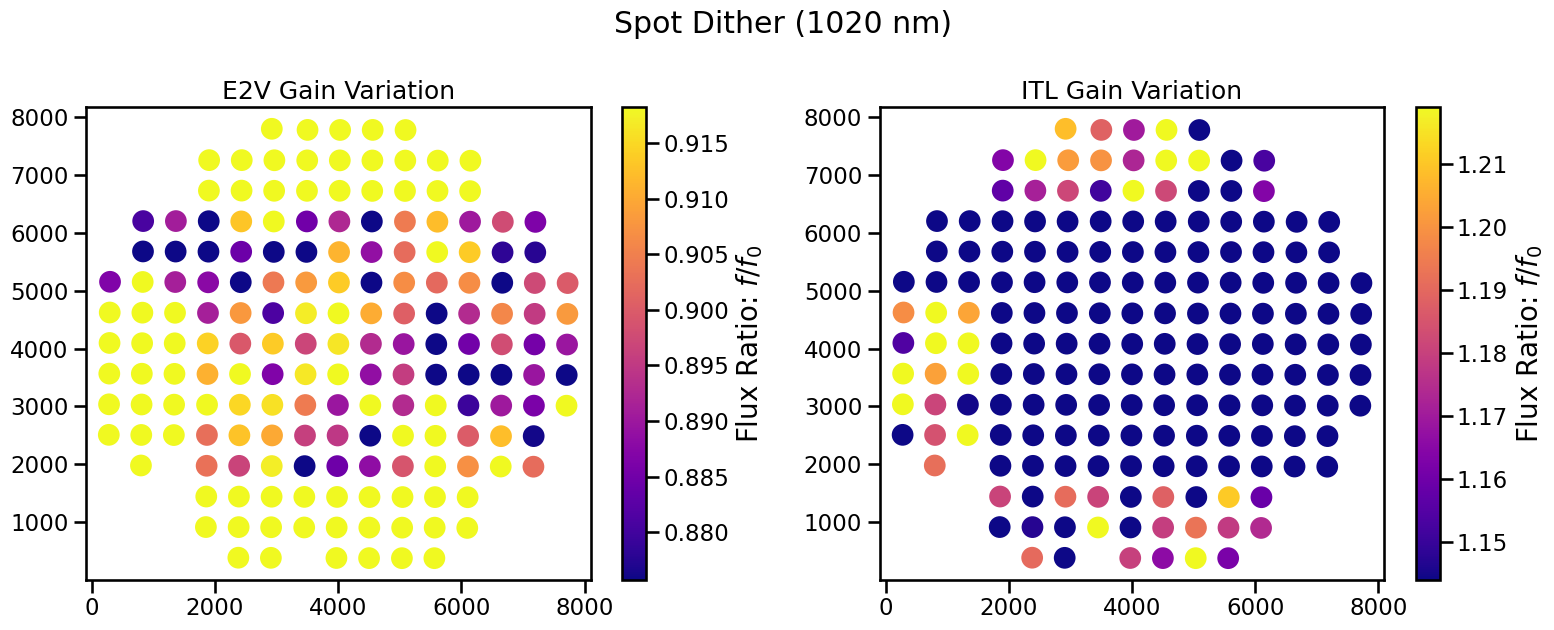

In [28]:
plt.figure(figsize=(16,6.5))
plt.subplot(1,2,1)
fm = np.nanmean(dflux[~itl])
fms = np.nanstd(dflux[~itl])
plt.scatter(data['xpeak'],data['ypeak'],c=dflux,vmin=fm-fms,vmax=fm+fms,cmap='plasma',s=200)
plt.colorbar().set_label(r'Flux Ratio: $ f/f_0$',fontsize=20)
plt.title('E2V Gain Variation')

plt.subplot(1,2,2)
fm = np.nanmean(dflux[itl])
fms = np.nanstd(dflux[itl])
plt.scatter(data['xpeak'],data['ypeak'],c=dflux,vmin=fm-fms,vmax=fm+fms,cmap='plasma',s=200)
plt.colorbar().set_label(r'Flux Ratio: $ f/f_0$',fontsize=20)
plt.title('ITL Gain Variation')


plt.suptitle(r'Spot Dither (1020 nm)')
plt.tight_layout()
plt.savefig(r'full_focal_plane_spot_temp_variation_1020nm.png',dpi=150)

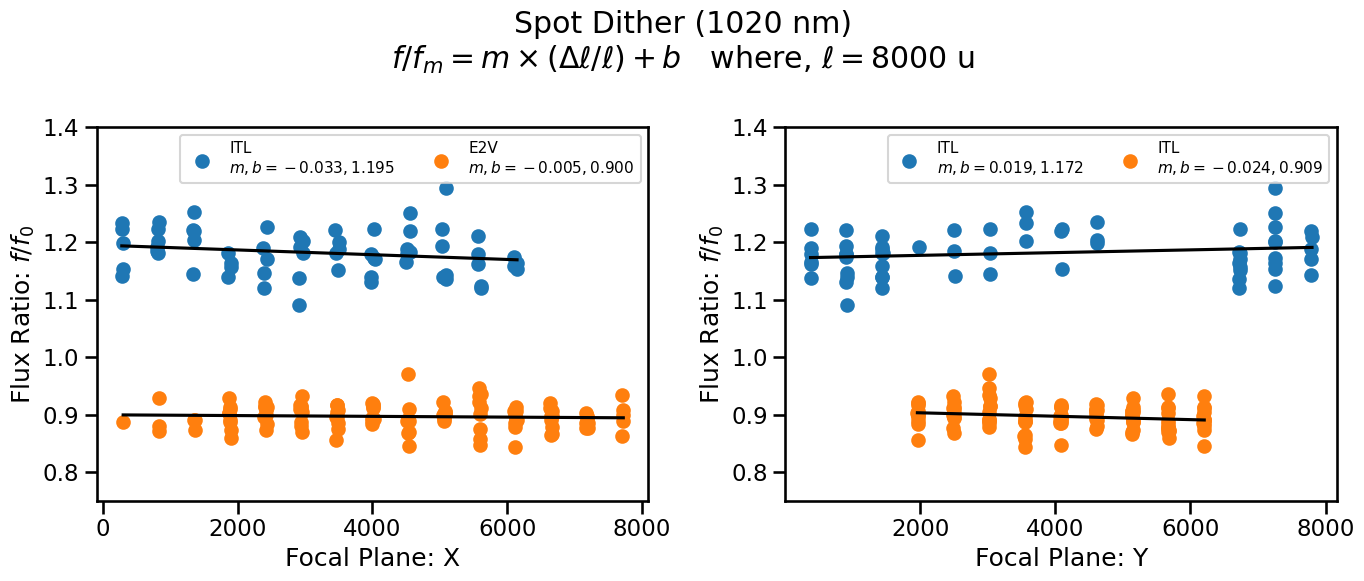

In [29]:
plt.figure(figsize=(14,6.))
plt.subplot(1,2,1)
plot_gradient(data['xpeak'][itl],dflux[itl],label='ITL')
plot_gradient(data['xpeak'][~itl],dflux[~itl],label='E2V')
# plt.text(3300.0,1.48, r'Focal Plane Size: $\ell = 8000$ u',fontsize=14)
# plt.plot([],[],marker=None,alpha=0,label=r'$\ell = 8000$ u')
plt.suptitle('Spot Dither (1020 nm)\n' + r'$ f/f_m = m \times (\Delta \ell/ \ell) + b$'+r'   where, $\ell = 8000$ u')
plt.ylabel(r'Flux Ratio: $ f/f_0$')
plt.legend(fontsize=11,ncol=2)
plt.ylim(0.75,1.4)

plt.xlabel('Focal Plane: X')
plt.subplot(1,2,2)
plot_gradient(data['ypeak'][itl],dflux[itl],label='ITL')
plot_gradient(data['ypeak'][~itl],dflux[~itl],label='ITL')
plt.ylim(0.75,1.4)
plt.legend(fontsize=11,ncol=2)
plt.xlabel('Focal Plane: Y')
plt.ylabel(r'Flux Ratio: $ f/f_0$')
plt.tight_layout()
plt.savefig(r'temp_variation_gradient_1020nm.png',dpi=150)

## At 1050nm

In [72]:
flux = data2['flux']
print('Flux mean, std: %.2e, %.2e'%(flux.mean(),flux.std()))

Flux mean, std: 2.56e+06, 6.37e+05


In [73]:
flux = data2['flux']
dflux = flux/np.nanmean(flux)
data2['df'] = dflux

In [74]:
from scipy.optimize import curve_fit

x,y = np.array(data2['xpeak']), np.array(data2['ypeak'])
funcPlane = lambda x,a,b,c: a+b*x[0]/8000. +c*x[1]/8000.
pars, pc = curve_fit(funcPlane, [x,y], dflux)
yp = funcPlane([x,y],*pars)
rms = np.std(yp-dflux)
print('RMS: %.2f'%rms)
pars

RMS: 0.23


array([ 1.1905044 , -0.32992129, -0.05037462])

In [84]:
pars, pc = curve_fit(funcPlane, [x[itl],y[itl]], dflux[itl])
yp = funcPlane([x[itl],y[itl]],*pars)
res = dflux[itl]-yp
rms = np.std(res)
print('RMS: %.3f'%rms)
pars

RMS: 0.071


array([ 1.33792879, -0.09834416,  0.05031339])

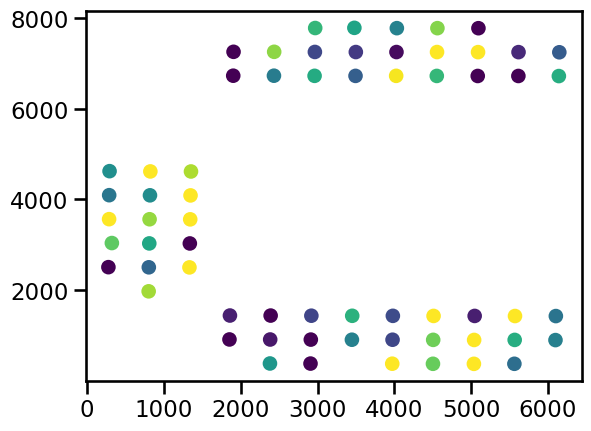

In [86]:
# plt.scatter(x[itl],y[itl],c=res)
plt.scatter(x[itl],y[itl],c=res+pars[0],vmin=pars[0]-rms,vmax=pars[0]+rms)
# plt.scatter(x[itl],y[itl],c=dflux[itl],vmin=pars[0]-rms,vmax=pars[0]+rms)

In [88]:
pars, pc = curve_fit(funcPlane, [x[~itl], y[~itl]], dflux[~itl])
yp = funcPlane([x[~itl],y[~itl]],*pars)
res = dflux[~itl]-yp
rms = np.std(res)
print('RMS: %.3f'%rms)
pars

RMS: 0.029


array([ 0.83754707, -0.00933369, -0.02992499])

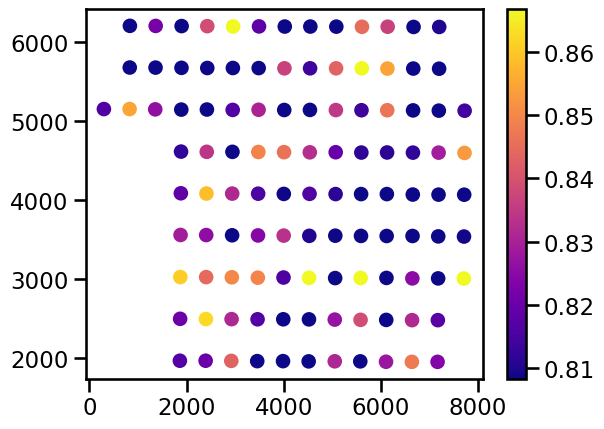

In [94]:
# plt.scatter(x[~itl],y[~itl],c=res+pars[0],vmin=pars[0]-rms,vmax=pars[0]+rms,cmap='plasma')
plt.scatter(x[~itl],y[~itl],c=dflux[~itl],vmin=pars[0]-rms,vmax=pars[0]+rms,cmap='plasma')
plt.colorbar()

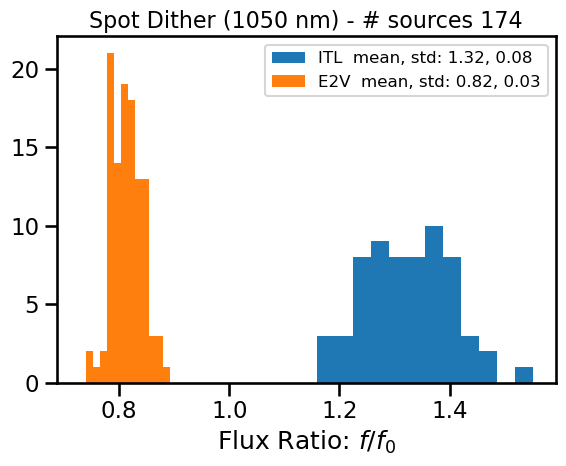

In [63]:
plt.figure(figsize=(6,5))
itl = dflux>1.
plot_hist(dflux[itl],label='ITL')
plot_hist(dflux[~itl],label='E2V')
plt.legend(fontsize=12,loc=1)
plt.xlabel(r'Flux Ratio: $ f/f_0$')
plt.title(f'Spot Dither (1050 nm) - # sources {len(data)}',fontsize=16)
plt.tight_layout()
plt.savefig(r'flux_dist_spot_temp_variation_1050nm.png',dpi=150)

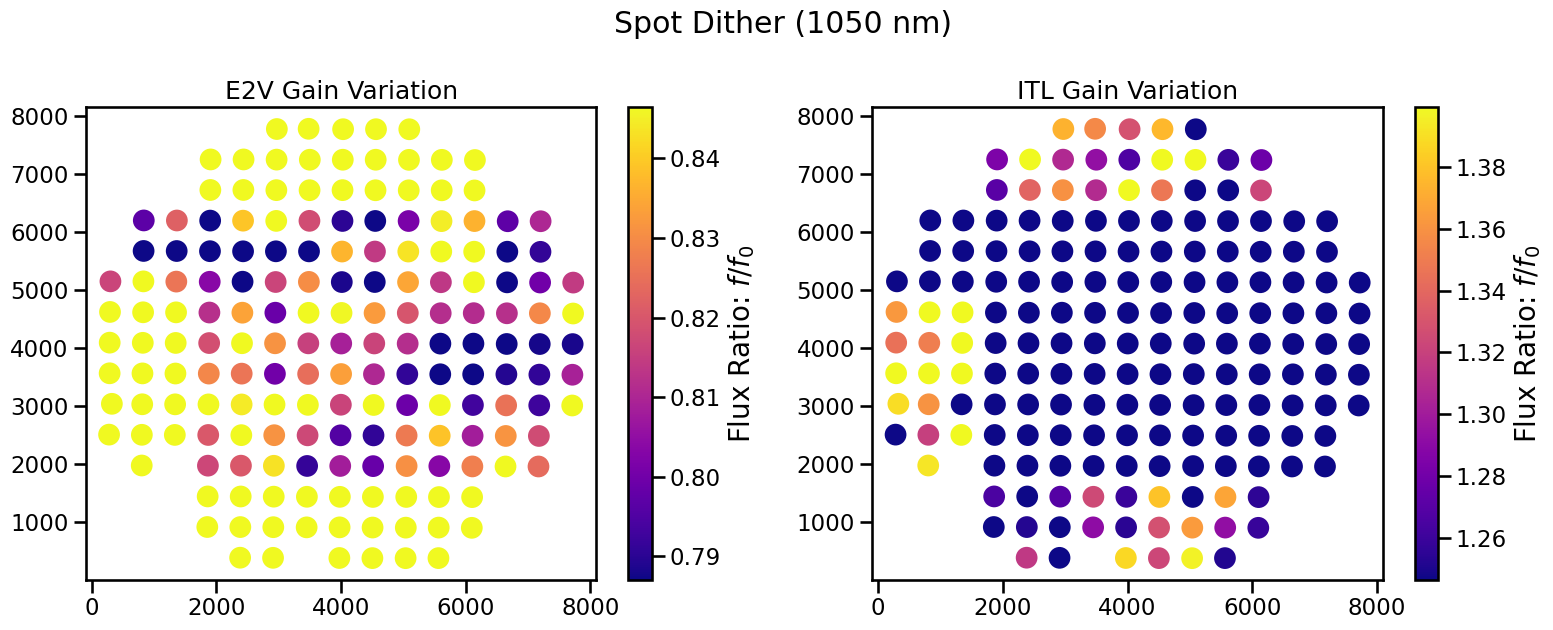

In [33]:
plt.figure(figsize=(16,6.5))
plt.subplot(1,2,1)
fm = np.nanmean(dflux[~itl])
fms = np.nanstd(dflux[~itl])
plt.scatter(data2['xpeak'],data2['ypeak'],c=dflux,vmin=fm-fms,vmax=fm+fms,cmap='plasma',s=200)
plt.colorbar().set_label(r'Flux Ratio: $ f/f_0$',fontsize=20)
plt.title('E2V Gain Variation')

plt.subplot(1,2,2)
fm = np.nanmean(dflux[itl])
fms = np.nanstd(dflux[itl])
plt.scatter(data2['xpeak'],data2['ypeak'],c=dflux,vmin=fm-fms,vmax=fm+fms,cmap='plasma',s=200)
plt.colorbar().set_label(r'Flux Ratio: $ f/f_0$',fontsize=20)
plt.title('ITL Gain Variation')
plt.suptitle(r'Spot Dither (1050 nm)')
plt.tight_layout()

plt.savefig(r'full_focal_plane_spot_temp_variation_1050nm.png',dpi=150)

In [34]:
itl_down = (dflux>1.0) & (data2['ypeak']>2000)
itl_up = (dflux>1.0) & (data2['ypeak']>6000)

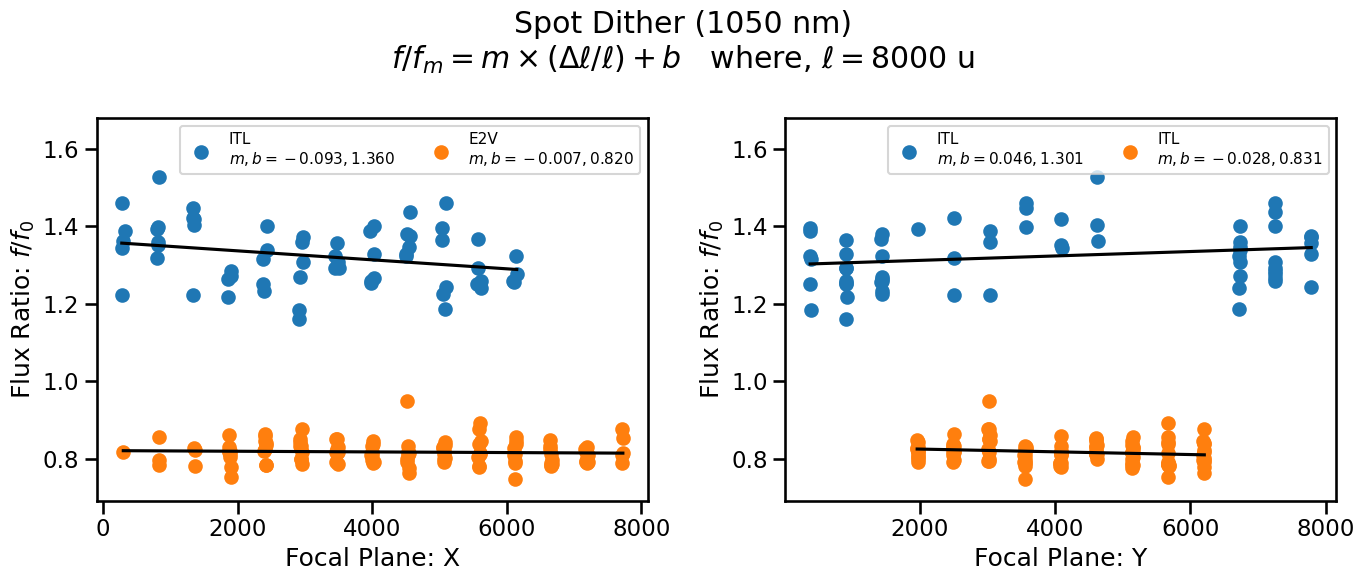

In [35]:
plt.figure(figsize=(14,6.))
plt.subplot(1,2,1)
plot_gradient(data2['xpeak'][itl],dflux[itl],label='ITL')
plot_gradient(data2['xpeak'][~itl],dflux[~itl],label='E2V')
# plt.text(3300.0,1.48, r'Focal Plane Size: $\ell = 8000$ u',fontsize=14)
# plt.plot([],[],marker=None,alpha=0,label=r'$\ell = 8000$ u')
plt.suptitle('Spot Dither (1050 nm)\n' + r'$ f/f_m = m \times (\Delta \ell/ \ell) + b$'+r'   where, $\ell = 8000$ u')
plt.ylabel(r'Flux Ratio: $ f/f_0$')
plt.legend(fontsize=11,ncol=2)
plt.ylim(0.69,1.68)

plt.xlabel('Focal Plane: X')
plt.subplot(1,2,2)
plot_gradient(data2['ypeak'][itl],dflux[itl],label='ITL')
plot_gradient(data2['ypeak'][~itl],dflux[~itl],label='ITL')
plt.ylim(0.69,1.68)
plt.legend(fontsize=11,ncol=2)
plt.xlabel('Focal Plane: Y')
plt.ylabel(r'Flux Ratio: $ f/f_0$')
plt.tight_layout()
plt.savefig(r'temp_variation_gradient_1050nm.png',dpi=150)

## Wavelenght Difference

In [36]:
flux = data2['flux']
dflux2 = flux/np.nanmean(flux)

flux = data['flux']
dflux = flux/np.nanmean(flux)

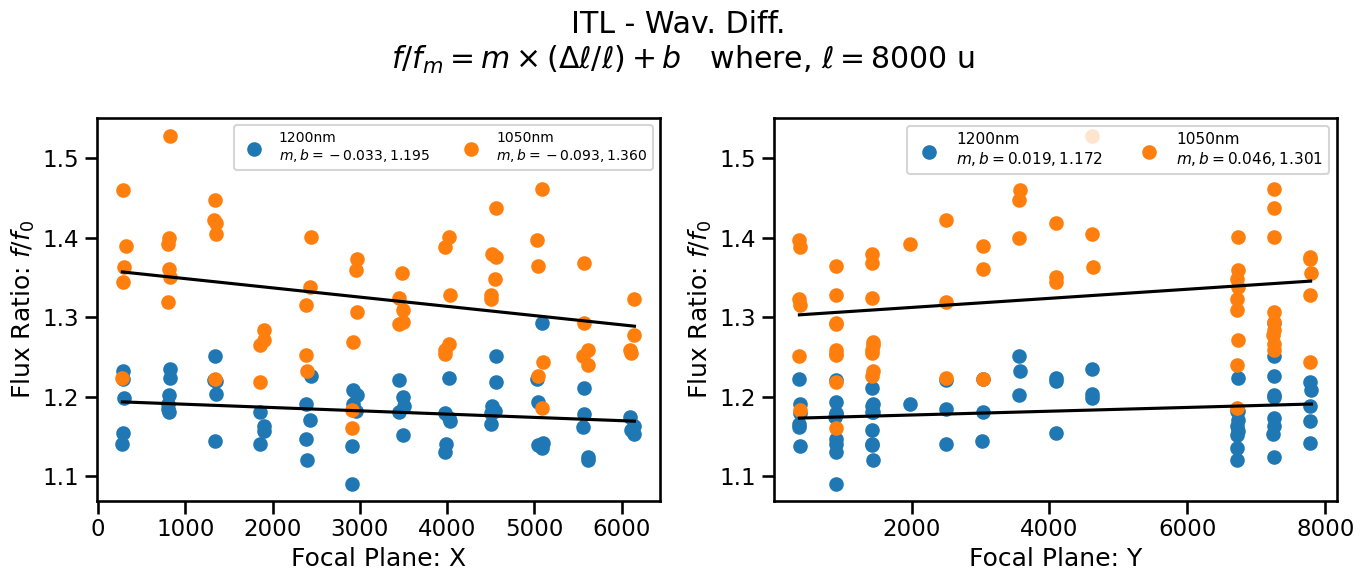

In [37]:
plt.figure(figsize=(14,6.))
plt.subplot(1,2,1)
plot_gradient(data['xpeak'][itl],dflux[itl],label='1200nm')
plot_gradient(data2['xpeak'][itl],dflux2[itl],label='1050nm')
# plt.text(3300.0,1.48, r'Focal Plane Size: $\ell = 8000$ u',fontsize=14)
# plt.plot([],[],marker=None,alpha=0,label=r'$\ell = 8000$ u')
plt.suptitle('ITL - Wav. Diff. \n' + r'$ f/f_m = m \times (\Delta \ell/ \ell) + b$'+r'   where, $\ell = 8000$ u')
plt.ylabel(r'Flux Ratio: $ f/f_0$')
plt.legend(fontsize=10,ncol=2)
# plt.ylim(0.69,1.68)

plt.xlabel('Focal Plane: X')
plt.subplot(1,2,2)
plot_gradient(data['ypeak'][itl],dflux[itl],label='1200nm')
plot_gradient(data2['ypeak'][itl],dflux2[itl],label='1050nm')
# plt.ylim(1.0,1.68)
plt.legend(fontsize=11,ncol=2)
plt.xlabel('Focal Plane: Y')
plt.ylabel(r'Flux Ratio: $ f/f_0$')
plt.tight_layout()
plt.savefig(r'temp_variation_gradient_itl_wav_diff.png',dpi=150)

In [38]:
data.write('full_focal_plane_spot_temp_variation_1020nm_sources.csv',overwrite=True)

In [39]:
data2.write('full_focal_plane_spot_temp_variation_1050nm_sources.csv',overwrite=True)